In [1]:
import torch
import torchvision
import PIL
import os
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
#加载所有数据,并切分为训练集和测试集
files_train = []
files_test = []

for file in os.listdir('pic'):
    if random.random() < 0.95:
        files_train.append(file)
        continue
    if 'copy' in file or 'flip' in file:
        continue
    files_test.append(file)

random.shuffle(files_train)
random.shuffle(files_test)

len(files_train), len(files_test)

(54246, 1724)

In [3]:
#打印数据集统计信息
def statistics_info(files):
    ls = {0: 0, 1: 0, 2: 0}
    ts = {0: 0, 1: 0, 2: 0}

    cross = {}

    for i in range(len(files)):
        level = int(files[i][0])
        type_ = int(files[i][2])

        ls[level] += 1
        ts[type_] += 1

        if '%d%d' % (level, type_) not in cross:
            cross['%d%d' % (level, type_)] = 0

        cross['%d%d' % (level, type_)] += 1

    print('total:', len(files))
    print('ls:', ls)
    print('ts:', ts)
    print('cross:', cross)


statistics_info(files_train)
statistics_info(files_test)

total: 54246
ls: {0: 26224, 1: 17253, 2: 10769}
ts: {0: 21393, 1: 12427, 2: 20426}
cross: {'22': 8067, '00': 17962, '12': 9285, '01': 5188, '11': 5616, '10': 2352, '02': 3074, '20': 1079, '21': 1623}
total: 1724
ls: {0: 1361, 1: 216, 2: 147}
ts: {0: 977, 1: 337, 2: 410}
cross: {'00': 935, '02': 173, '12': 121, '21': 17, '01': 253, '10': 28, '22': 116, '11': 67, '20': 14}


In [4]:
#数据预处理函数
preprocess = torchvision.transforms.Compose([
    lambda x: PIL.Image.open(x).convert('RGB'),
    #裁剪尺寸
    torchvision.transforms.Resize((169, 300)),
    #随机训传-15到15度
    #torchvision.transforms.RandomRotation(15),
    #中心裁剪到64像素,去除黑边
    #torchvision.transforms.CenterCrop(224),
    #随机左右翻转
    torchvision.transforms.RandomHorizontalFlip(),
    #转tensor
    torchvision.transforms.ToTensor(),
    #数据标准化
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])


#加载文件为图片
def load_file(file):
    file = 'pic/' + file
    return preprocess(file)


x = load_file(files_train[0])
x[:1], x.shape

(tensor([[[1.5810, 1.5982, 1.6153,  ..., 1.9920, 1.9578, 1.7352],
          [1.5982, 1.6153, 1.6153,  ..., 1.9235, 1.8893, 1.7694],
          [1.5982, 1.6153, 1.6324,  ..., 1.8550, 1.8037, 1.8037],
          ...,
          [1.4954, 1.5125, 1.5125,  ..., 2.2318, 2.2318, 2.2318],
          [1.4783, 1.4954, 1.4954,  ..., 2.2318, 2.2318, 2.2318],
          [1.4783, 1.4783, 1.4783,  ..., 2.2318, 2.2318, 2.2318]]]),
 torch.Size([3, 169, 300]))

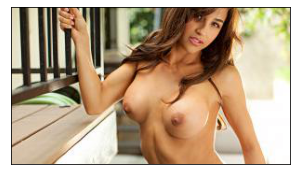

In [5]:
#显示图片
def show(x):
    #还原normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(1)
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(1)
    x = x * std + mean

    #c,w,h转换为w,h,c
    x = x.permute(1, 2, 0)

    #还原到0-255
    x *= 255

    x = x.numpy().astype(np.uint8)
    x = PIL.Image.fromarray(x, mode='RGB')
    plt.figure(figsize=(5, 5))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x)
    plt.show()


show(x)

In [6]:
#定义数据集
class Dataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.x = []
        self.y = []

        for file in files:
            self.x.append(file)
            self.y.append(int(file[0]))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        x = load_file(self.x[i])
        y = self.y[i]
        if y == 2:
            y = 1
        return x, torch.tensor(y)


dataloader_train = torch.utils.data.DataLoader(dataset=Dataset(files_train),
                                               batch_size=50,
                                               shuffle=True,
                                               drop_last=True)

dataloader_test = torch.utils.data.DataLoader(dataset=Dataset(files_test),
                                              batch_size=50,
                                              shuffle=True,
                                              drop_last=True)

for i, (x, y) in enumerate(dataloader_train):
    break

x[:2, :2, :2], x.shape, y

(tensor([[[[1.8722, 1.8722, 1.8722,  ..., 1.8722, 1.8722, 1.8722],
           [1.8722, 1.8722, 1.8722,  ..., 1.8722, 1.8722, 1.8722]],
 
          [[0.9580, 0.9580, 0.9580,  ..., 0.9580, 0.9580, 0.9580],
           [0.9580, 0.9580, 0.9580,  ..., 0.9580, 0.9580, 0.9580]]],
 
 
         [[[1.9920, 1.9920, 1.9920,  ..., 1.9749, 1.9749, 1.9749],
           [1.9920, 1.9920, 1.9920,  ..., 1.9920, 1.9920, 1.9920]],
 
          [[2.2710, 2.2710, 2.2710,  ..., 2.2535, 2.2535, 2.2535],
           [2.2710, 2.2710, 2.2710,  ..., 2.2710, 2.2710, 2.2710]]]]),
 torch.Size([50, 3, 169, 300]),
 tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         1, 0]))

In [7]:
#使用torchvision提供的训练好的resnet18层模型'
resnet18 = torchvision.models.resnet18(pretrained=True)

#剪掉最后一层
resnet18 = list(resnet18.children())[:-1]

#不需要计算梯度
# for i in resnet18:
#     for j in i.parameters():
#         j.requires_grad = False

#重新组装成model
resnet18 = torch.nn.Sequential(*resnet18)

#不需要计算梯度
resnet18.eval()

#试算
out = resnet18(x)
out.shape

torch.Size([50, 512, 1, 1])

In [8]:
#迁移学习模型,就是个简单的线性模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(in_features=512, out_features=512),
            torch.nn.ReLU(), torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=512, out_features=2))

    def forward(self, x):
        return self.fc(x)


model = Model()
model(out.squeeze()).shape

torch.Size([50, 2])

In [9]:
#训练模型
def train(train_resnet18=False):
    optimizer_model = torch.optim.Adam(model.parameters(), lr=1e-4)
    optimizer_resnet18 = torch.optim.Adam(resnet18.parameters(), lr=1e-6)
    criteon = torch.nn.CrossEntropyLoss()

    #训练
    model.train()

    resnet18.eval()
    if train_resnet18:
        resnet18.train()

    for i, (x, y) in enumerate(dataloader_train):

        optimizer_model.zero_grad()
        optimizer_resnet18.zero_grad()

        #模型运算
        out = resnet18(x).squeeze()
        out = model(out)

        #梯度下降
        loss = criteon(out, y)
        loss.backward()
        optimizer_model.step()

        if train_resnet18:
            optimizer_resnet18.step()

        if i % 10 == 0:
            out = out.argmax(dim=-1)
            accurecy = (out == y).sum() / float(len(y))
            print(i, loss.item(), accurecy.item())


# train()

# #保存模型
# torch.save(model.state_dict(), 'model.mdl')

In [10]:
#计算在测试集的正确率
def test(print_error=False, print_not_sure=False):
    model.eval()
    resnet18.eval()

    #统计正确率
    correct = 0
    total = 0

    #统计查准率,查全率
    pred_1_1 = 0
    pred_1 = 0
    real_1 = 0

    #统计确定和不确定的数量
    sure = 0
    not_sure = 0

    #置信度阈值
    threshold = 0.75

    for i, (x, y) in enumerate(dataloader_test):
        with torch.no_grad():
            #统计总数
            total += len(y)

            #模型运算
            #[50, 3, 169, 300] -> [50, 512, 1, 1]
            out = resnet18(x)

            #[50, 512, 1, 1] -> [50, 512]
            out = out.squeeze()

            #[50, 512] -> [50, 2]
            out = model(out)

            #正负两类概率恒正,且相加等于1,便于后面求置信度
            #[50, 2] -> [50, 2]
            out = torch.nn.functional.softmax(out, dim=-1)

            #求置信度
            #[50, 2] -> [50]
            confidence = out.max(dim=-1).values

            #置信度小于阈值的为不确定的分类结果,交由人工处理
            not_sure += (confidence < threshold).sum().item()

            if print_not_sure:
                for xi, yi, outi in zip(x[confidence < threshold],
                                        y[confidence < threshold],
                                        out[confidence < threshold]):
                    show(xi)
                    print('yi=', yi.item(), 'outi=',
                          outi.argmax().item(), 'confidence=', outi)

            #取出置信度大于阈值的结果
            out = out[confidence > threshold]
            y = y[confidence > threshold]
            confidence = confidence[confidence > threshold]

            #取出分类结果
            #[50, 2] -> [50]
            out = out.argmax(dim=-1)

            #统计正确率
            correct += (out == y).sum().item()
            sure += len(y)

            #统计查准率,查全率
            pred_1_1 += (out[y == 1] == 1).sum().item()
            pred_1 += (out == 1).sum().item()
            real_1 += (y == 1).sum().item()

            if print_error:
                for xi, yi, outi, confidencei in zip(x, y, out, confidence):
                    if yi != outi:
                        show(xi)
                        print('yi=', yi.item(), 'outi=', outi.item(),
                              'confidencei=', confidencei.item())

        if i % 10 == 0:
            print(
                'i=',
                i,
                'total=',
                total,
                'correct=',
                correct,
                'sure=',
                sure,
                'not_sure=',
                not_sure,
            )

    accurecy = correct / sure

    #查准率描述:当模型判定为违规时,真的违规的概率
    #查准率=正确判定违规数/判定违规数
    precision = pred_1_1 / pred_1

    #查全率描述:当违规时,被模型发现的概率
    #查全率=正确判定违规数/真实违规数
    recall = pred_1_1 / real_1

    return accurecy, precision, recall, sure, not_sure, total


#加载模型
model.load_state_dict(torch.load('model.mdl'))

test(print_error=False, print_not_sure=False)

i= 0 total= 50 correct= 32 sure= 36 not_sure= 14
i= 10 total= 550 correct= 412 sure= 449 not_sure= 101
i= 20 total= 1050 correct= 800 sure= 856 not_sure= 194
i= 30 total= 1550 correct= 1178 sure= 1261 not_sure= 289


(0.9337700145560408, 0.7941176470588235, 0.8966789667896679, 1374, 326, 1700)

In [11]:
#加载模型
model.load_state_dict(torch.load('model.mdl'))

train(train_resnet18=True)

#保存模型
torch.save(model.state_dict(), 'model_fine.mdl')
torch.save(resnet18.state_dict(), 'resnet18_fine.mdl')

0 0.3584812581539154 0.8399999737739563
10 0.22427624464035034 0.8999999761581421
20 0.1652584969997406 0.9599999785423279
30 0.12850065529346466 0.9399999976158142
40 0.13099125027656555 0.9800000190734863
50 0.304435133934021 0.8600000143051147
60 0.2986556589603424 0.8600000143051147
70 0.32527512311935425 0.8799999952316284
80 0.17844504117965698 0.8999999761581421
90 0.3077496588230133 0.8399999737739563
100 0.23165585100650787 0.9200000166893005
110 0.2510012686252594 0.8399999737739563
120 0.3491014540195465 0.8799999952316284
130 0.2809806764125824 0.800000011920929
140 0.17445605993270874 0.9599999785423279
150 0.24653014540672302 0.8799999952316284
160 0.32921165227890015 0.8199999928474426
170 0.19431909918785095 0.8799999952316284
180 0.2557288110256195 0.8999999761581421
190 0.33361145853996277 0.8399999737739563
200 0.23664377629756927 0.8799999952316284
210 0.1995258927345276 0.9200000166893005
220 0.21135593950748444 0.8600000143051147
230 0.27342137694358826 0.86000001

In [12]:
#加载模型
model.load_state_dict(torch.load('model_fine.mdl'))
resnet18.load_state_dict(torch.load('resnet18_fine.mdl'))

test(print_error=False, print_not_sure=False)

i= 0 total= 50 correct= 35 sure= 41 not_sure= 9
i= 10 total= 550 correct= 432 sure= 463 not_sure= 87
i= 20 total= 1050 correct= 820 sure= 876 not_sure= 174
i= 30 total= 1550 correct= 1221 sure= 1297 not_sure= 253


(0.9424157303370787, 0.8424657534246576, 0.8723404255319149, 1424, 276, 1700)